In [1]:
%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import mne

# EEG and ET sync

In [2]:
# read the preprocessed data for the subject
et_data = pd.read_excel('Project1 Recording002.xlsx')
et_data.head()

,Recording timestamp [μs],Computer timestamp [μs],Sensor,Project name,Export date,Participant name,Recording name,Recording date,Recording date UTC,Recording start time,...,Eye movement type index,Fixation point X [MCS px],Fixation point Y [MCS px],Ungrouped,Gyro X [°/s],Gyro Y [°/s],Gyro Z [°/s],Accelerometer X [m/s²],Accelerometer Y [m/s²],Accelerometer Z [m/s²]
0,0,12,NaN,Project1,03-03-2025,ET001_SD043 (2),Recording002,22-02-2025,22-02-2025,12:15:05.013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,12,NaN,Project1,03-03-2025,ET001_SD043 (2),Recording002,22-02-2025,22-02-2025,12:15:05.013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,12,NaN,Project1,03-03-2025,ET001_SD043 (2),Recording002,22-02-2025,22-02-2025,12:15:05.013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,13,NaN,Project1,03-03-2025,ET001_SD043 (2),Recording002,22-02-2025,22-02-2025,12:15:05.013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,14,NaN,Project1,03-03-2025,ET001_SD043 (2),Recording002,22-02-2025,22-02-2025,12:15:05.013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# read te raw livedata.json.gz file for extra information
et_raw = pd.read_json('livedata.json.gz', lines=True)
et_raw = et_raw.rename(columns=dict(
    ts='timestamp',
    s='valid',
    ac='acceleration',
    gy='gyroscope',
    gd='gazedir',
    pc='pupilcenter',
    pd='pupildia',
    gp='gazepos',
    gp3='gazepos3D',
    vts='vidtime',
    dir='syncdir',
    sig='syncsig'
))
et_raw.head()

,timestamp,valid,acceleration,gyroscope,gidx,gazedir,eye,pupilcenter,pupildia,l,gazepos,gazepos3D,pts,pv,vidtime,syncdir,syncsig
0,595609132,0,"[-0.9410000000000001, -9.859, 2.6029999999999998]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,595618816,0,"[-1.02, -9.852, 2.565]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,595628500,0,"[-0.981, -9.807, 2.533]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,595638184,0,"[-0.981, -9.859, 2.6029999999999998]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,595647868,0,"[-0.981, -9.852, 2.565]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Sync signals

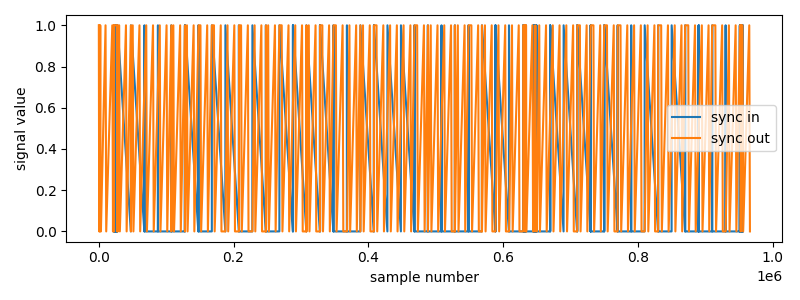

In [4]:
f, ax = plt.subplots(1, 1, figsize=(8, 3), tight_layout=True)
et_raw.groupby('syncdir')['syncsig'].apply(lambda s: s.plot(ax=ax, label=f'sync {s.name}'))
ax.legend()
ax.set_xlabel('sample number')
ax.set_ylabel('signal value');

## Timestamps of sync_in pulses

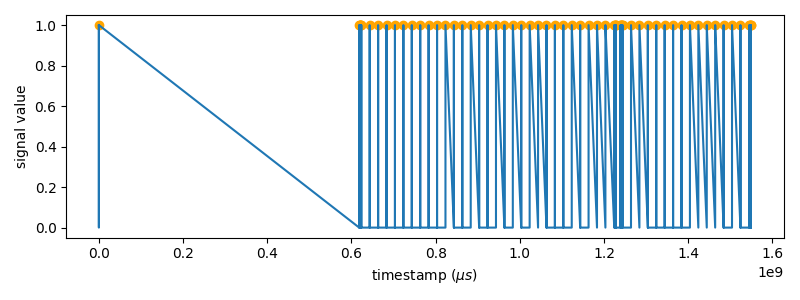

In [65]:
# extract the columns for timestamp and syncin signal
df = et_raw[et_raw.syncdir=='in'][['timestamp', 'syncsig']].set_index('timestamp').sort_index()
# only keep rows where sync in turns 1
df = df[df.syncsig==1]
# find such points that are at least 5 seconds apart
sync_ts = df[df.index.diff().fillna(700000)>400000].index

# verify
f, ax = plt.subplots(1, 1, figsize=(8, 3), tight_layout=True)
et_raw[et_raw.syncdir=='in'].set_index('timestamp')['syncsig'].sort_index().plot(ax=ax)
ax.scatter(sync_ts, [1]*len(sync_ts), c='orange')
ax.set_xlabel('timestamp ($\mu s$)')
ax.set_ylabel('signal value');

## Use sync_ts to sync ET with EEG data

In [67]:
eeg_data = mne.io.read_raw_brainvision('ET001_SD043.vhdr')

Extracting parameters from ET001_SD043.vhdr...
Setting channel info structure...


In [85]:
# extract trigger annotations
annots = eeg_data.annotations.to_data_frame()
# convert onset times to time in seconds from the EEG start (orig_time)
annots['onset'] = (
    pd.to_datetime(annots.onset, utc=True) - eeg_data.annotations.orig_time.astimezone(None)
).map(lambda x: x.total_seconds())
# filter events corresponding to the first 5 pulses
eeg_trig_ts = annots[annots.description.isin(['Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13'])].onset
eeg_trig_ts

2      44.547
3      45.552
4      46.552
5      47.551
6      48.551
7      49.552
8      69.533
9      89.530
10    109.527
11    129.525
12    149.522
13    169.519
14    189.516
15    209.514
16    229.511
17    249.508
18    269.505
19    289.503
20    309.499
21    329.497
22    349.493
23    369.492
24    389.489
25    409.486
26    429.483
27    449.480
28    469.478
29    489.475
30    509.473
31    529.470
32    549.467
33    569.464
34    589.461
35    609.457
36    629.456
37    650.452
38    651.468
39    652.468
40    653.468
41    654.467
Name: onset, dtype: float64

In [95]:
# combine the EEG and ET timestamps into a single dataframe
ET_EEG_sync_df = pd.DataFrame(
    index=['EEG', 'ET'],
    data=[eeg_trig_ts.values, sync_ts[1:1+len(eeg_trig_ts)]]
).T.rename_axis(index='trigger number')
ET_EEG_sync_df

,EEG,ET
trigger number,,
0,44.547,6.183460e+08
1,45.552,6.193512e+08
2,46.552,6.203510e+08
3,47.551,6.213519e+08
4,48.551,6.223501e+08
5,49.552,6.233508e+08
6,69.533,6.433324e+08
7,89.530,6.633290e+08
8,109.527,6.833275e+08


In [96]:
# use ET_EEG_sync_df to convert ET times to EEG times
m, c = np.polyfit(ET_EEG_sync_df.ET, ET_EEG_sync_df.EEG, 1)

# update the computer time in et_data 
et_data['EEG time'] = et_data['Computer timestamp [μs]']*m+c
et_data.head().set_index('EEG time')

,Recording timestamp [μs],Computer timestamp [μs],Sensor,Project name,Export date,Participant name,Recording name,Recording date,Recording date UTC,Recording start time,...,Eye movement type index,Fixation point X [MCS px],Fixation point Y [MCS px],Ungrouped,Gyro X [°/s],Gyro Y [°/s],Gyro Z [°/s],Accelerometer X [m/s²],Accelerometer Y [m/s²],Accelerometer Z [m/s²]
EEG time,,,,,,,,,,,,,,,,,,,,,
-573.810463,0,12,NaN,Project1,03-03-2025,ET001_SD043 (2),Recording002,22-02-2025,22-02-2025,12:15:05.013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-573.810463,0,12,NaN,Project1,03-03-2025,ET001_SD043 (2),Recording002,22-02-2025,22-02-2025,12:15:05.013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-573.810463,0,12,NaN,Project1,03-03-2025,ET001_SD043 (2),Recording002,22-02-2025,22-02-2025,12:15:05.013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-573.810462,1,13,NaN,Project1,03-03-2025,ET001_SD043 (2),Recording002,22-02-2025,22-02-2025,12:15:05.013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-573.810461,2,14,NaN,Project1,03-03-2025,ET001_SD043 (2),Recording002,22-02-2025,22-02-2025,12:15:05.013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Verify goodness of fit

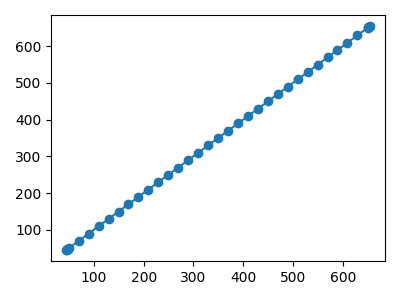

In [99]:
f, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
ax.scatter(eeg_trig_ts.values, sync_ts[1:1+len(eeg_trig_ts)]*m+c)
ax.plot(eeg_trig_ts.values, eeg_trig_ts.values);

## Single function to synchronize ET and EEG

In [88]:
def align_to_EEG(et_data, et_raw, eeg_data):
    '''
    Inputs:
    et_data: pd.read_excel('Project1 Recording002.xlsx')
    et_raw: pd.read_json('livedata.json.gz', lines=True)
    eeg_data: mne.io.read_raw_brainvision('ET001_SD043.vhdr')

    Returns:
    et_data with added column `EEG time`
    m, c: coefficients of linear fit to the first 5 triggers
    '''
    
    et_raw = et_raw.rename(columns=dict( ts='timestamp', dir='syncdir', sig='syncsig'))
    
    # extract the columns for timestamp and syncin signal
    df = et_raw[et_raw.syncdir=='in'][['timestamp', 'syncsig']].set_index('timestamp').sort_index()
    # only keep rows where sync in turns 1
    df = df[df.syncsig==1]
    # find such points that are at least 5 seconds apart
    sync_ts = df[df.index.diff().fillna(700000)>400000].index

    # extract trigger annotations
    annots = eeg_data.annotations.to_data_frame()
    # convert onset times to time in seconds from the EEG start (orig_time)
    annots['onset'] = (
        pd.to_datetime(annots.onset, utc=True) - eeg_data.annotations.orig_time.astimezone(None)
    ).map(lambda x: x.total_seconds())
    # filter events corresponding to the first 5 pulses
    eeg_trig_ts = annots[annots.description.isin(['Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13'])].onset

    # combine the EEG and ET timestamps into a single dataframe
    ET_EEG_sync_df = pd.DataFrame(
        index=['EEG', 'ET'],
        data=[eeg_trig_ts.values, sync_ts[1:1+len(eeg_trig_ts)]]
    ).T.rename_axis(index='trigger number')

    # use ET_EEG_sync_df to convert ET times to EEG times
    m, c = np.polyfit(ET_EEG_sync_df.ET, ET_EEG_sync_df.EEG, 1)
    
    # update the computer time in et_data 
    et_data['EEG time'] = et_data['Computer timestamp [μs]']*m+c

    return et_data, m, c

# EEG and ET video sync
Note that if there are more frames, the times for those frames will have to be interpolated from this

In [102]:
# add eeg time to the et_raw data
et_raw['eegtime'] = et_raw['timestamp']*m+c
et_raw.set_index('eegtime', inplace=True)

# the index below is the timestamp for the frames in EEG time
# note that in this example we have 1510 frames every 0.64 s
# for a total of 965.8 seconds (~16 mins)
frame_times = et_raw.vidtime.dropna().index
frame_times, np.nanmean(frame_times.diff()), np.nanmean(frame_times.diff())*len(frame_times)

(Index([22.228160260920617, 22.867548039103553, 23.507178821382922,
        24.146841604201654,  24.78643638587414,  25.42606816817033,
        26.065724950887898, 26.705387733706743, 27.345019516002935,
        27.984614297675307,
        ...
         981.6711576263687,  982.3107854085973,  982.9503851903543,
          983.590011972566,  984.2296427548455,  984.8692735371247,
         985.5088703188309,  986.1485011011101,  986.7881638839291,
         987.4277906661408],
       dtype='float64', name='eegtime', length=1510),
 0.6396286483798675,
 965.8392590536)